In [1]:
# Cats vs Dogs CNN


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms,datasets
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
import zipfile

from PIL import Image
from torchsummary import summary
import time
from torch.utils.tensorboard import SummaryWriter


reprocess_data = True
import seaborn as sns

In [2]:
train_path = "./train"
train_files = os.listdir(train_path)


In [3]:
print(len(train_files))

25000


In [4]:
imgpath = os.path.join(train_path,train_files[0])
print(imgpath)

./train/dog.8011.jpg


In [5]:
img = cv2.imread(imgpath,0)
type(img)

numpy.ndarray

In [6]:
imgtensor = torch.tensor(img)
imgtensor.shape

torch.Size([500, 380])

In [7]:

class Dataset():
    def __init__(self,filelist,filepath,transform = None):
        self.filelist = filelist
        self.filepath = filepath
        self.transform = transform
    def __len__(self):
        return int(len(self.filelist))
    def __getitem__(self,index):
        imgpath = os.path.join(self.filepath,self.filelist[index])
        img = Image.open(imgpath)
        if "dog" in imgpath:
            label = 1
        else:
            label = 0 
        if self.transform is not None:
            img = self.transform(img)
        return (img,label)
            

In [8]:
transformations = transforms.Compose([transforms.Resize((60,60)),transforms.ToTensor()])
train = Dataset(train_files,train_path,transformations)

train_set,test_set = torch.utils.data.random_split(train,[20000,5000]) 

In [9]:
test_set.__getitem__(0)[0].shape

torch.Size([3, 60, 60])

In [10]:
train_dataset = torch.utils.data.DataLoader(dataset = train_set,batch_size = 32,shuffle=True)
test_dataset = torch.utils.data.DataLoader(dataset = test_set,batch_size = 32,shuffle=True)

In [11]:
class Convnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,16,5), #3 channels in, 16 out, kernel size 5
            nn.ReLU(),
            nn.MaxPool2d(2,2)
            ) 
            
        self.conv2 =   nn.Sequential(
            nn.Conv2d(16,32,5), #16 channels in, 32 out, kernel size 5
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        ) 
        self.conv3 =   nn.Sequential(
            nn.Conv2d(32,64,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        ) 

        self.fc1 = nn.Sequential(
                nn.Flatten(),
                nn.Linear(64*4*4,256), 
                nn.ReLU(),
                nn.Linear(256,128),
                nn.ReLU()
        )
            
        self.fc2 = nn.Sequential(
        nn.Linear(128,2),
        )
                
    def forward(self,x):
        x= self.conv1(x)
        x= self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return F.softmax(x,dim = 1) 

In [12]:
model = Convnet()
summary(model,(3,60,60))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 56, 56]           1,216
              ReLU-2           [-1, 16, 56, 56]               0
         MaxPool2d-3           [-1, 16, 28, 28]               0
            Conv2d-4           [-1, 32, 24, 24]          12,832
              ReLU-5           [-1, 32, 24, 24]               0
         MaxPool2d-6           [-1, 32, 12, 12]               0
            Conv2d-7             [-1, 64, 8, 8]          51,264
              ReLU-8             [-1, 64, 8, 8]               0
         MaxPool2d-9             [-1, 64, 4, 4]               0
          Flatten-10                 [-1, 1024]               0
           Linear-11                  [-1, 256]         262,400
             ReLU-12                  [-1, 256]               0
           Linear-13                  [-1, 128]          32,896
             ReLU-14                  [

In [13]:
EPOCHS = 100
optimizer = optim.Adam(model.parameters(),lr=0.0005)

LOSS = nn.CrossEntropyLoss()

In [14]:
for epoch in range(EPOCHS):  # loop over the dataset multiple times
    total = 0
    correct = 0
    train_loss = 0
    train_accuracy = 0
    counter = 0
    train_running_loss =0
    for inputs, data in enumerate(train_dataset, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs) #forward
        loss = LOSS(outputs, labels) #calculate loss 
        loss.backward() #backward
        optimizer.step() #optimize
        
        train_running_loss+= loss.item() * inputs.size(0)
        _,pred = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    train_accuracy = correct/total
    train_loss = train_running_loss/len(train_set)
    print("=====/train/=====")
    print("epoch {} train accuracy {}".format(epoch+1,train_accuracy))
    print("epoch {} train loss {}".format(epoch+1,train_loss))  
    
    
    if epoch %1 == 0:
        model.eval()
        total = 0
        correct = 0
        test_loss = 0
        test_accuarcy =0
        test_running_loss = 0
        with torch.no_grad():
            for test_data,test_label in test_dataset:
    
                test_output = model(test_data)

                loss_test = LOSS(test_output,test_label)
                
                test_running_loss+= loss_test.item() * test_data.size(0) #loss value by batchsize
                _,pred = torch.max(test_output.data,1)    
                total += test_label.size(0)
                correct += (pred == test_label).sum().item()
            test_accuracy = correct/total
            #calcuate loss per epoch by dividing runing loss by number of items in validation set
            test_loss = test_running_loss/len(test_set)
            print(test_running_loss)
            print("=====/test/=====")
            print("epoch {} test accuracy {}".format(epoch+1,test_accuracy))
            print("epoch {} test loss {}".format(epoch+1,test_loss))
            

            
print('Finished Training')

=====/train/=====
epoch 1 train accuracy 0.57605
epoch 1 train loss 0.6730114074707031
3157.5595321655273
=====/test/=====
epoch 1 test accuracy 0.6544
epoch 1 test loss 0.6315119064331055
=====/train/=====
epoch 2 train accuracy 0.6778
epoch 2 train loss 0.6079846827030182
2968.2904539108276
=====/test/=====
epoch 2 test accuracy 0.692
epoch 2 test loss 0.5936580907821656
=====/train/=====
epoch 3 train accuracy 0.73395
epoch 3 train loss 0.5605742975711823
2743.007294654846
=====/test/=====
epoch 3 test accuracy 0.7448
epoch 3 test loss 0.5486014589309692
=====/train/=====
epoch 4 train accuracy 0.7638
epoch 4 train loss 0.532633677816391
2647.3581233024597
=====/test/=====
epoch 4 test accuracy 0.7704
epoch 4 test loss 0.5294716246604919
=====/train/=====
epoch 5 train accuracy 0.7846
epoch 5 train loss 0.5179319253444672
2596.230166196823
=====/test/=====
epoch 5 test accuracy 0.7822
epoch 5 test loss 0.5192460332393646
=====/train/=====
epoch 6 train accuracy 0.7977
epoch 6 train 

=====/train/=====
epoch 44 train accuracy 0.95315
epoch 44 train loss 0.3591646780967712
2592.7406311035156
=====/test/=====
epoch 44 test accuracy 0.7906
epoch 44 test loss 0.5185481262207031
=====/train/=====
epoch 45 train accuracy 0.9559
epoch 45 train loss 0.35673705286979673
2594.671966075897
=====/test/=====
epoch 45 test accuracy 0.7888
epoch 45 test loss 0.5189343932151794
=====/train/=====
epoch 46 train accuracy 0.95545
epoch 46 train loss 0.3572976123332977
2534.363320350647
=====/test/=====
epoch 46 test accuracy 0.8038
epoch 46 test loss 0.5068726640701294
=====/train/=====
epoch 47 train accuracy 0.9579
epoch 47 train loss 0.35473563289642335
2591.913809776306
=====/test/=====
epoch 47 test accuracy 0.7906
epoch 47 test loss 0.5183827619552612
=====/train/=====
epoch 48 train accuracy 0.9554
epoch 48 train loss 0.3573328033924103
2577.218590736389
=====/test/=====
epoch 48 test accuracy 0.7926
epoch 48 test loss 0.5154437181472779
=====/train/=====
epoch 49 train accurac

=====/train/=====
epoch 87 train accuracy 0.9712
epoch 87 train loss 0.3416547486305237
2600.357629776001
=====/test/=====
epoch 87 test accuracy 0.7902
epoch 87 test loss 0.5200715259552002
=====/train/=====
epoch 88 train accuracy 0.9712
epoch 88 train loss 0.34138394675254824
2576.2877099514008
=====/test/=====
epoch 88 test accuracy 0.7924
epoch 88 test loss 0.5152575419902802
=====/train/=====
epoch 89 train accuracy 0.9719
epoch 89 train loss 0.3409240589618683
2572.8604080677032
=====/test/=====
epoch 89 test accuracy 0.7946
epoch 89 test loss 0.5145720816135406
=====/train/=====
epoch 90 train accuracy 0.97115
epoch 90 train loss 0.3416848117351532
2587.1363513469696
=====/test/=====
epoch 90 test accuracy 0.7918
epoch 90 test loss 0.517427270269394
=====/train/=====
epoch 91 train accuracy 0.9713
epoch 91 train loss 0.3413553447246552
2560.704693555832
=====/test/=====
epoch 91 test accuracy 0.7984
epoch 91 test loss 0.5121409387111664
=====/train/=====
epoch 92 train accuracy

In [15]:
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy() #numpy function
    plt.figure(figsize = (16,9))
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #transpose the image
    plt.show()


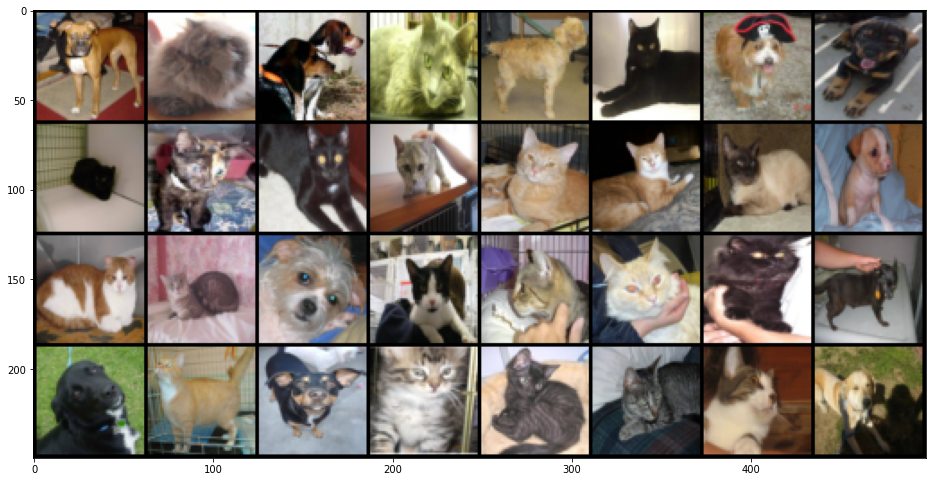

In [16]:
dataiter = iter(test_dataset)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
#print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [17]:
outputs = model(images)
print(outputs)

tensor([[6.7341e-28, 1.0000e+00],
        [2.8257e-01, 7.1743e-01],
        [1.1316e-22, 1.0000e+00],
        [1.0000e+00, 3.3410e-11],
        [4.7074e-01, 5.2926e-01],
        [1.0000e+00, 0.0000e+00],
        [1.5808e-26, 1.0000e+00],
        [1.8051e-32, 1.0000e+00],
        [1.0000e+00, 1.1165e-12],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 2.1851e-10],
        [1.4426e-02, 9.8557e-01],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 2.3780e-14],
        [1.0000e+00, 7.9994e-10],
        [5.0795e-35, 1.0000e+00],
        [1.0000e+00, 2.6344e-06],
        [1.0000e+00, 3.1634e-24],
        [2.4963e-23, 1.0000e+00],
        [1.6398e-02, 9.8360e-01],
        [1.0000e+00, 2.3544e-11],
        [1.0000e+00, 0.0000e+00],
        [8.6254e-17, 1.0000e+00],
        [9.9598e-01, 4.0193e-03],
        [2.4256e-15, 1.0000e+00],
        [1.0000e+00, 1.7355e-25],
        [4.6289e-04, 9.9954e-01],
        [9.9860e-01, 1.3991e-03],
        [1.0000e+00, 3.2455e-24],
        [1.000

In [18]:
_, predicted = torch.max(outputs, 1)

correct = 0
total = 0
with torch.no_grad():
    for data in test_dataset:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))




Accuracy of the network on the 10000 test images: 78 %
